# Segment Anything Model using transformers 🤗 library

## References

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb

@article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}

In [2]:
import pandas as pd
cases = pd.read_csv('datasets\correct_cases_book.csv')
cases.head()

,Unnamed: 0,index,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
0,0,0,D-4522-1,4,LEFT,MLO,NaN,normals,NaN,2596,5386,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.LEFT_MLO.tif
1,1,1,D-4522-1,4,RIGHT,CC,NaN,normals,NaN,2146,4726,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.RIGHT_CC.tif
2,2,2,D-4522-1,4,LEFT,CC,NaN,normals,NaN,2251,4576,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.LEFT_CC.tif
3,3,3,D-4522-1,4,RIGHT,MLO,NaN,normals,NaN,2296,5071,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.RIGHT_MLO.tif
4,4,4,D-4587-1,3,LEFT,MLO,NaN,normals,NaN,2506,5161,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4587_1.LEFT_MLO.tif


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [8]:
from PIL import Image
import cv2
import io
import requests
from skimage.morphology import disk
from transformers import SamModel, SamProcessor
import torch

model = SamModel.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
device = "cuda" if torch.cuda.is_available() else "cpu"

def find_centroid(img):
    img = np.array(img, dtype=np.uint8)
    _, binary_mask = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, disk(9))
    masked_image = cv2.bitwise_and(img, img, mask=opened_mask)
    contours, _ = cv2.findContours(masked_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return [cX, cY]

def decode_masks(masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()
    for mask,scores in sorted(zip(masks,scores), key=lambda item: item[1], reverse=True):
      h, w = mask.shape[-2:]
      yield np.array(mask.reshape(h, w, 1)).astype(np.uint8)

def preprocessing(case):
    # Load the image from the URL
    raw_image = np.array(Image.open(io.BytesIO(requests.get('http://127.0.0.1:9000/ddsm/od_images/'+case).content)))
    centroid = find_centroid(raw_image)
    rgb_raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    
    inputs = processor(rgb_raw_image, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    
    input_points = [[centroid]]
    
    inputs = processor(rgb_raw_image, input_points=input_points, return_tensors="pt").to(device)
    # pop the pixel_values as they are not neded
    inputs.pop("pixel_values", None)
    inputs.update({"image_embeddings": image_embeddings})

    with torch.no_grad():
        outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    scores = outputs.iou_scores
    
    mask = next(decode_masks(masks[0], scores))
    masked_image = cv2.bitwise_and(raw_image,raw_image,mask=mask)
    contours, _ = cv2.findContours(masked_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    largest_contour = max(contours, key=cv2.contourArea)
    contour_image = np.zeros_like(raw_image)
    cv2.drawContours(contour_image, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
    contour_image = cv2.bitwise_and(masked_image,contour_image)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_img = contour_image[y:y+h, x:x+w]

    """
       Furthermore, we use magma color mapping from 16-bit grayscale to 24-bit RGB,
    """
    false_colored_img = cv2.applyColorMap(cropped_img, cv2.COLORMAP_MAGMA)

    return cv2.resize(false_colored_img, (224, 336))

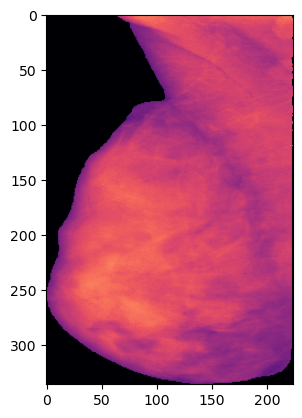

In [9]:
plt.imshow(cv2.cvtColor(preprocessing(cases['minio_path'][0]), cv2.COLOR_BGR2RGB));

In [ ]:
import concurrent
import os

def try_preprocessing(case):
   content = preprocessing(case)
   with open(os.path.join('datasets/experiment-1-preprocessed-mammograms-with-sam', f'{case}.npy'), 'wb') as file:
           np.save(file,content)
   return case
    
N = len(cases['minio_path'])
with concurrent.futures.ThreadPoolExecutor(max_workers=os. cpu_count()-2) as executor:
    future_to_value = {executor.submit(try_preprocessing, case): case for case in cases['minio_path']}
    index = 0
    for future in concurrent.futures.as_completed(future_to_value):
        case = future_to_value[future]
        index += 1
        print(f"{index*100/N:.2f}%          ",end="\r")
        try:
            future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (case, exc))

'D_4563_1.RIGHT_MLO.tif' generated an exception: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1073741824 bytes.


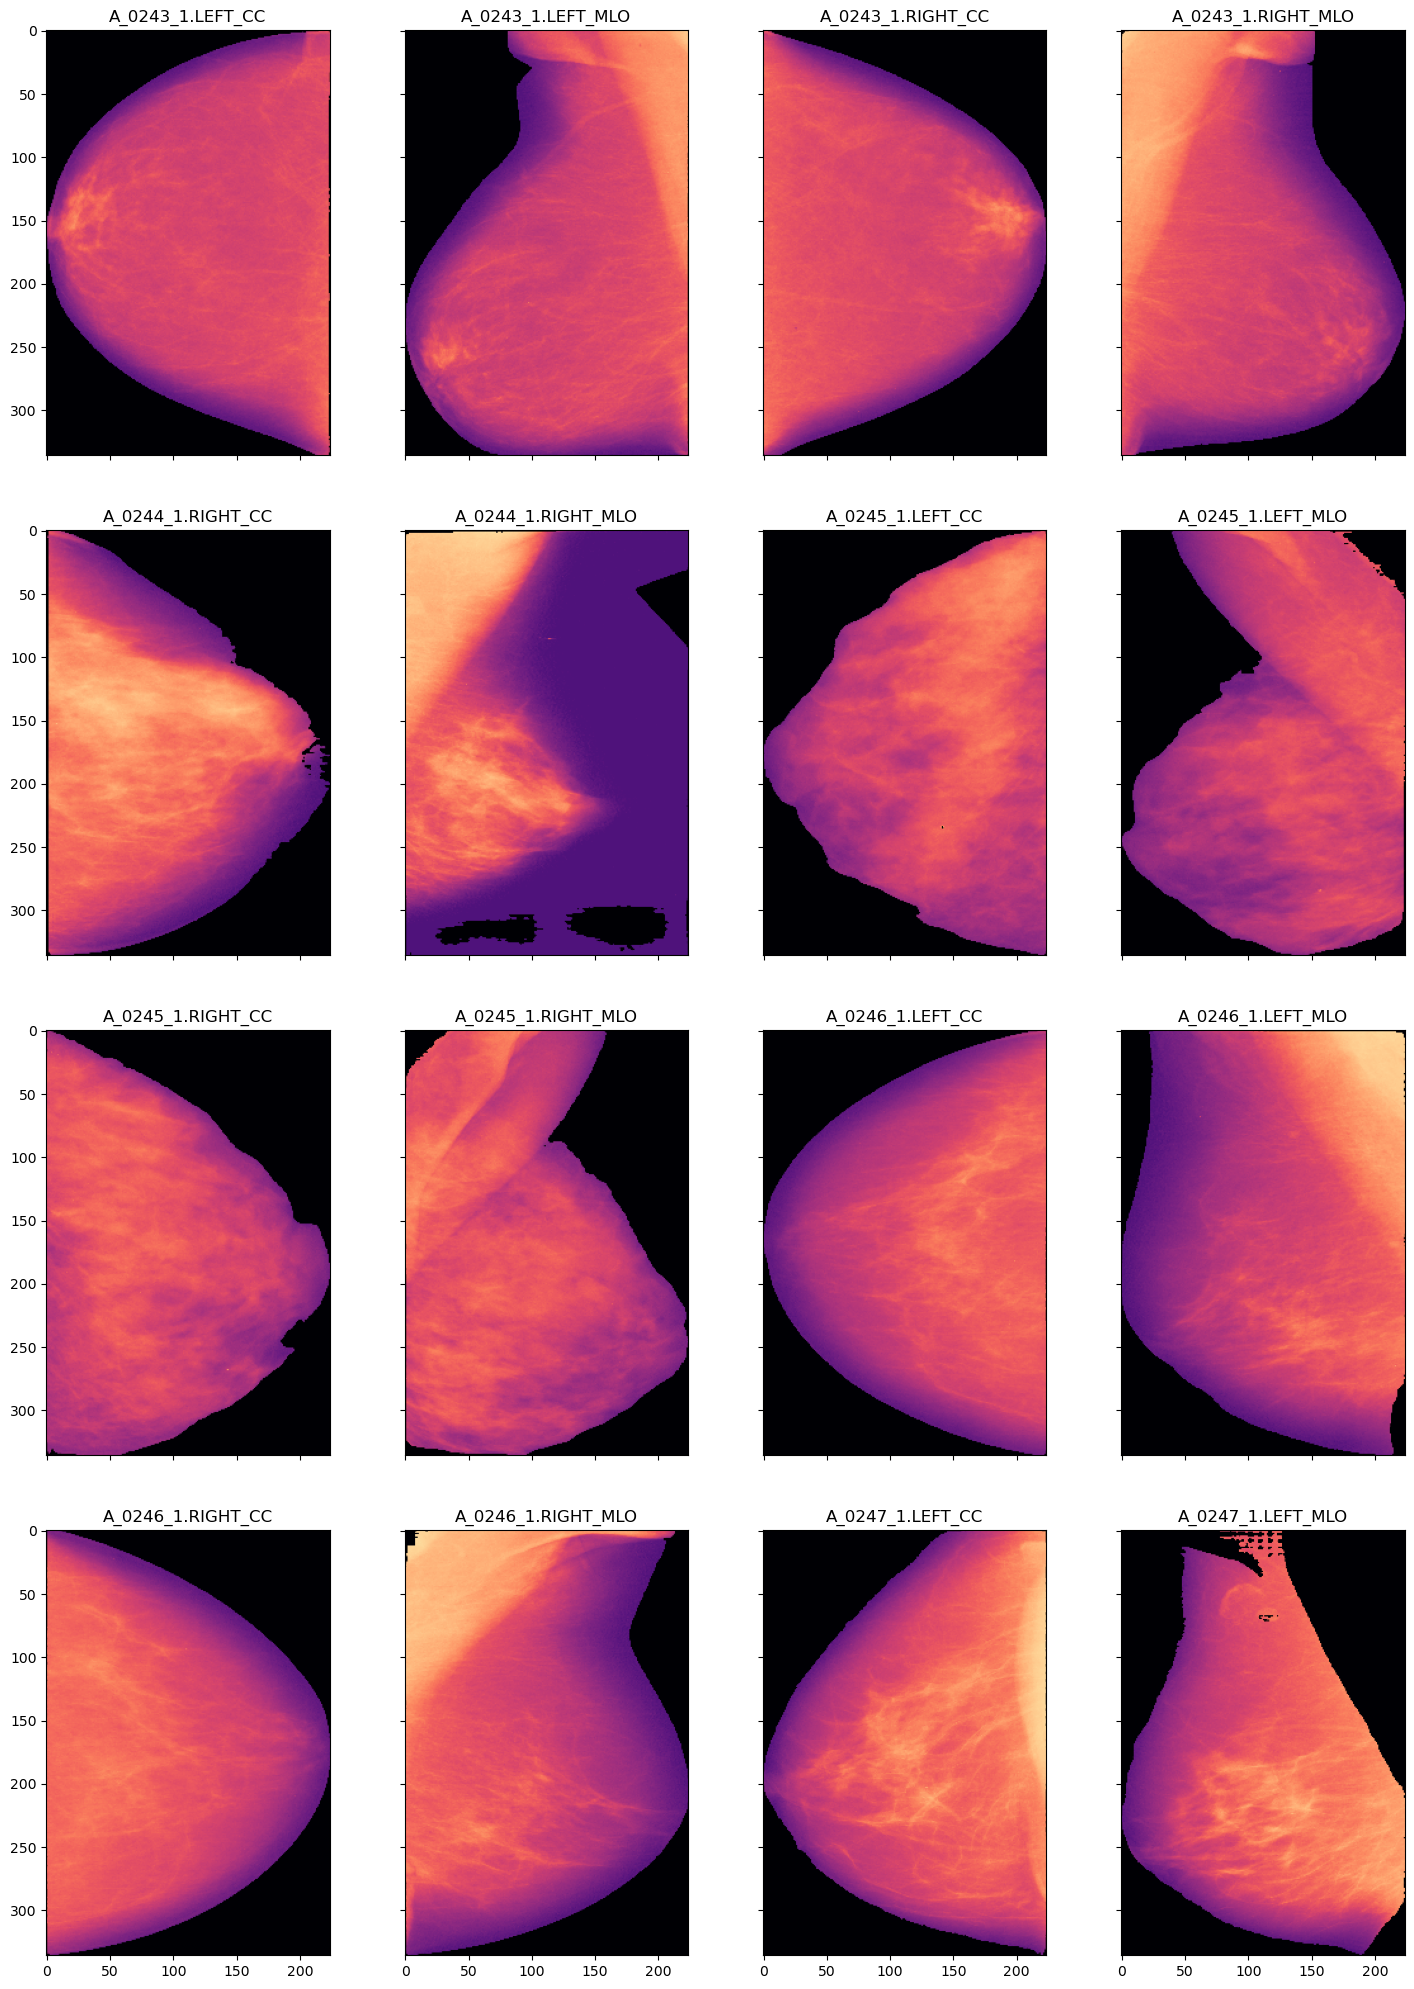

In [11]:
from PIL import Image
import cv2
import requests
import io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import glob

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,nrows_ncols=(4, 4),axes_pad=0.75,)

def load_numpy(path):
    with open(path, 'rb') as file:
        return np.load(file)
    
for ax, case in zip(grid, glob.glob('datasets/experiment-1-preprocessed-mammograms-with-sam/*.npy')):
    try:
     ax.set_title(case.replace('datasets/experiment-1-preprocessed-mammograms-with-sam\\', '').replace('.npy', '').replace('.tif', ''))
     ax.imshow(cv2.cvtColor(load_numpy(case), cv2.COLOR_BGR2RGB))
    except Exception as e:
      print(case, " Error: ",str(e))

# Manual preprocessing

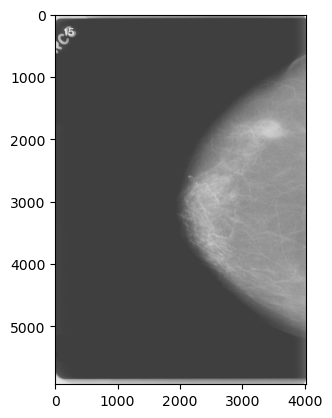

In [25]:
filename = 'C_0231_1.RIGHT_CC.tif'
raw_image = np.array(Image.open(io.BytesIO(requests.get('http://127.0.0.1:9000/ddsm/od_images/'+filename).content)))
rgb_raw_image = cv2.cvtColor(raw_image,cv2.COLOR_BGR2RGB)
plt.imshow(rgb_raw_image);

In [17]:
inputs = processor(rgb_raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

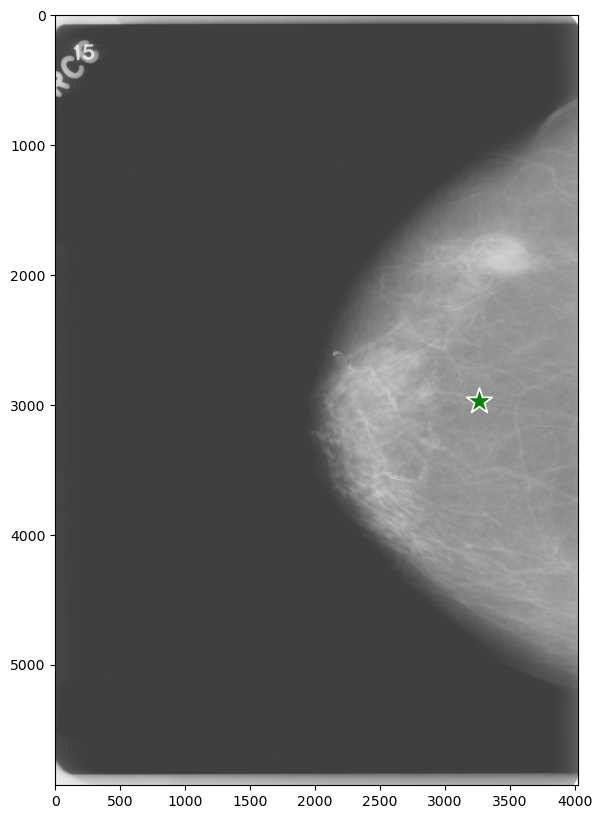

In [18]:
input_points = [[find_centroid(raw_image)]]
show_points_on_image(rgb_raw_image, input_points[0])

In [19]:
inputs = processor(rgb_raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

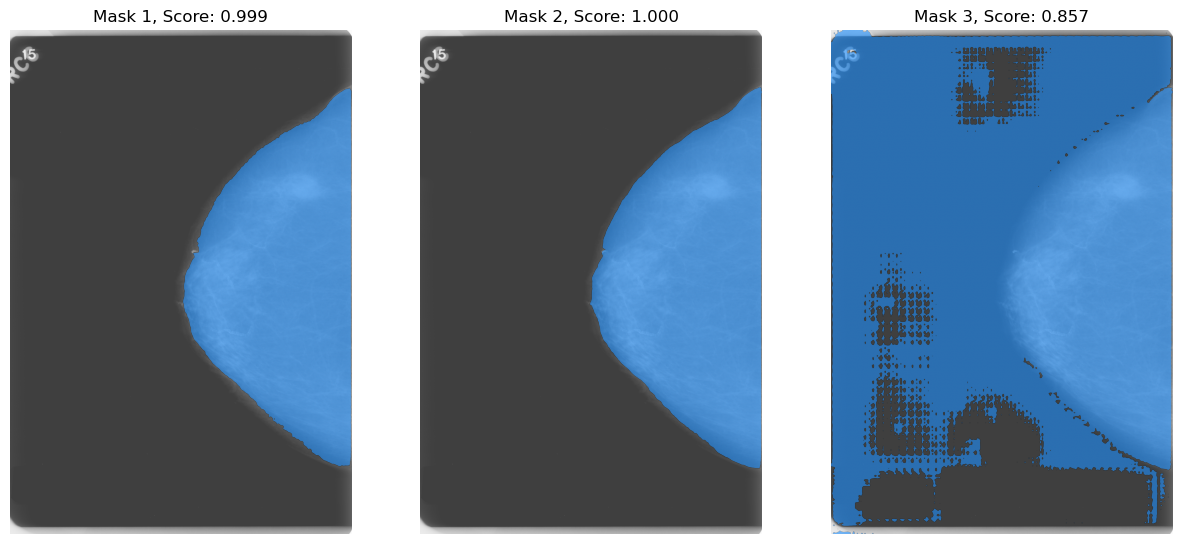

In [20]:
show_masks_on_image(rgb_raw_image, masks[0], scores)

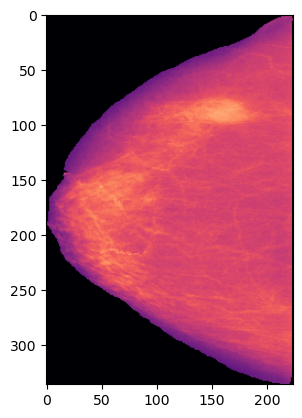

In [23]:
best_mask = next(decode_masks(masks[0], scores))
masked_image = cv2.bitwise_and(raw_image, raw_image, mask=best_mask)
contours, _ = cv2.findContours(masked_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
largest_contour = max(contours, key=cv2.contourArea)
contour_image = np.zeros_like(raw_image)
cv2.drawContours(contour_image, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
contour_image = cv2.bitwise_and(masked_image,contour_image)
x, y, w, h = cv2.boundingRect(largest_contour)
cropped_img = contour_image[y:y+h, x:x+w]
false_colored_img = cv2.applyColorMap(cropped_img, cv2.COLORMAP_MAGMA)
img = cv2.resize(false_colored_img, (224, 336))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

# COCO Example

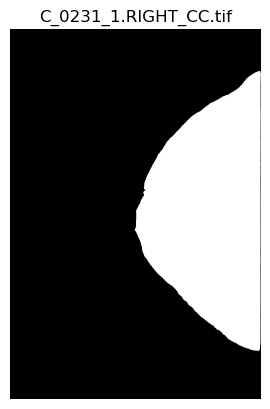

In [35]:
import matplotlib.pyplot as plt
import os
plt.figure()
plt.imshow(best_mask, cmap='gray')
plt.title(f'{os.path.basename(filename)}')
plt.axis('off')
plt.show() 

In [30]:
best_mask.shape,best_mask.dtype

((5928, 4024, 1), dtype('uint8'))

In [43]:
best_mask

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [42]:
import json
coco_format = {'images': [{'height': 4656,
   'width': 3016,
   'id': 1,
   'file_name': filename}],
 'annotations': [{'iscrowd': 0,
   'image_id': 1,
   'bbox': [0.0, 0.0, 1826.2926829268295, 4226.780487804877],
   'segmentation': best_mask, # best_mask.tolist()
   'category_id': 0,
   'id': 1,
   'area': 0}],
 'categories': [{'id': 0, 'name': '1', 'supercategory': '1'}]}

coco_format

{'images': [{'height': 4656,
   'width': 3016,
   'id': 1,
   'file_name': 'C_0231_1.RIGHT_CC.tif'}],
 'annotations': [{'iscrowd': 0,
   'image_id': 1,
   'bbox': [0.0, 0.0, 1826.2926829268295, 4226.780487804877],
   'segmentation': array([[[0],
           [0],
           [0],
           ...,
           [0],
           [0],
           [0]],
   
          [[0],
           [0],
           [0],
           ...,
           [0],
           [0],
           [0]],
   
          [[0],
           [0],
           [0],
           ...,
           [0],
           [0],
           [0]],
   
          ...,
   
          [[0],
           [0],
           [0],
           ...,
           [0],
           [0],
           [0]],
   
          [[0],
           [0],
           [0],
           ...,
           [0],
           [0],
           [0]],
   
          [[0],
           [0],
           [0],
           ...,
           [0],
           [0],
           [0]]], dtype=uint8),
   'category_id': 0,
   'id': 1,
   'a